# Air Quality Analysis: Milan vs. Paris 🇮🇹🇫🇷
**Author:** Seyed Alireza Hosseini  
**Date:** Feb 2026  
**Description:** A comparative analysis of PM2.5 levels in Milan and Paris to understand seasonal pollution trends using Python.


# Introduction
The objective of this project is to perform a comparative analysis of Particulate Matter (PM2.5) concentration in **Milan (Italy)** and **Paris (France)** for the year **2024**. Using the **OpenAQ v3 API**, we retrieve historical air quality data to identify seasonal trends, volatility, and compliance with World Health Organization (WHO) safety guidelines.

The analysis follows this workflow:
* **Data Acquisition:** Fetching location metadata and sensor data via API.
* **Data Cleaning:** Handling duplicates, removing invalid sensors, and formatting dates.
* **Visualization:** Generating Time Series, Boxplots, and Frequency Histograms.
* **Interpretation:** Qualitative analysis of the environmental patterns.

## 1. Library Import and API Configuration
In this step, we import the necessary Python libraries for data analysis and visualization (Pandas, Matplotlib, Seaborn, Requests).

We also configure the **OpenAQ v3 API** connection by defining the Base URL and the Authentication Header.
* **Why define the header?** The OpenAQ API requires an API Key for authentication. We store this key in a dictionary `{"X-API-Key": API_Key}` and pass it with every HTTP request. This ensures secure authentication without exposing the key in the URL string.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import time

API_Key= "a728f0f11f84fdadac5c6f29295b8ca8328a11a0c73addcfb5683e095636c464"
header= {"X-API-Key": API_Key}
URL= "https://api.openaq.org/v3"

## 2. Location Discovery (Function Definition)
In this step, we define a reusable function `locations()` to query the API for active monitoring stations.

**The Strategy:**
1.  **Broad Search (API Side):** We request all locations for a specific Country ID (91 for Italy, 22 for France) that measure PM2.5 (Parameter ID 2).
2.  **Narrow Filter (Client Side):** Since the API returns many cities, we loop through the results and filter them using a list of target names (checking for both "Milan" and "Milano" in Italy and "Paris" for France).

This approach ensures we capture all relevant sensors even if they are named slightly differently in the database.

**Note on Pagination:**
We request data using the `/days` aggregation endpoint with limit=1000. Since the year 2024 contains only 366 days, the entire dataset for each sensor fits within a single API response. Therefore, no complex pagination loop is required for this specific granularity.

In [2]:
def locations(country_id, city_name):
    local_URl = f"{URL}/locations"
    # filter by country and pm2.5 (id is 2)
    params= {"countries_id": country_id, "parameters_id": 2, "limit": 1000}
    response= requests.get(url= local_URl, params= params, headers= header)

    # check if the request failed
    if response.status_code!= 200:
        print(f"Error: {response.text}")
        return []

    data = response.json().get("results", [])

    target_locations= []
    
    # go through every location we found
    for loc in data:
        #get the name safely and make it lowercase to carefully check
        loc_name = loc.get('name', '').lower()
        
        # check against our city list (like 'milan' or 'milano')
        for city in city_name:
            if city.lower() in loc_name:
                target_locations.append(loc)
                break
                
    print(f"Found {len(target_locations)} locations matching {city_name}.")
    return target_locations

milan_locs = locations(91, ["Milan", "Milano"])
#milan_locs is a List that holds multiple Dictionaries.
paris_locs = locations(22, ["Paris"])
# take a peek at the data structure to see what we have
print(milan_locs)

Found 4 locations matching ['Milan', 'Milano'].
Found 5 locations matching ['Paris'].
[{'id': 8303, 'name': 'MILANO - SENATO', 'locality': 'VIA SENATO ANG MARINA - Milano (MI)', 'timezone': 'Europe/Rome', 'country': {'id': 91, 'code': 'IT', 'name': 'Italy'}, 'owner': {'id': 4, 'name': 'Unknown Governmental Organization'}, 'provider': {'id': 70, 'name': 'EEA'}, 'isMobile': False, 'isMonitor': True, 'instruments': [{'id': 2, 'name': 'Government Monitor'}], 'sensors': [{'id': 24162, 'name': 'co µg/m³', 'parameter': {'id': 4, 'name': 'co', 'units': 'µg/m³', 'displayName': 'CO mass'}}, {'id': 24161, 'name': 'no2 µg/m³', 'parameter': {'id': 5, 'name': 'no2', 'units': 'µg/m³', 'displayName': 'NO₂ mass'}}, {'id': 7773858, 'name': 'pm10 µg/m³', 'parameter': {'id': 1, 'name': 'pm10', 'units': 'µg/m³', 'displayName': 'PM10'}}, {'id': 7775178, 'name': 'pm25 µg/m³', 'parameter': {'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'displayName': 'PM2.5'}}], 'coordinates': {'latitude': 45.46972199987526, 'lo

## 3. Sensor Extraction
Once we have the locations, we need to extract the specific **Sensor IDs**.
A single location might have multiple sensors (e.g., Temperature, CO2, PM10). We define a function sensor() to loop through each location and pick only the sensors measuring PM2.5 (Parameter ID 2).

We store the results in a list of dictionaries containing the City, Location ID, and Sensor ID, which will be used for the data download.

In [3]:
def sensor(locations):
    sensors= []
    # loop through each location in the list
    for loc in locations:
        # check every sensor at that location
        for sensor in loc.get("sensors", []):
            # saving the pm2.5 data
            if sensor["parameter"]["id"] == 2:
                sensors.append({
                    "City": loc.get("name"),
                    "Location_id": loc["id"],
                    "Sensor_id": sensor["id"]})
    return sensors
# extract sensors for milan and paris
milan_sensors= sensor(milan_locs)
paris_sensors= sensor(paris_locs)
# peek at the result to make sure it worked
print(milan_sensors)
# combine everything into one list for easier processing
all_sensors = milan_sensors + paris_sensors


[{'City': 'MILANO - SENATO', 'Location_id': 8303, 'Sensor_id': 7775178}, {'City': 'MILANO PASCAL CITT� STUDI', 'Location_id': 8352, 'Sensor_id': 7773388}, {'City': 'MILANO - V.LE MARCHE', 'Location_id': 8357, 'Sensor_id': 7774326}, {'City': 'Milano', 'Location_id': 3293387, 'Sensor_id': 11484317}]


## 4. Data Retrieval Function
We define a helper function `data_sensors()` to handle the API request for a specific sensor.
* **Endpoint:** We use the `/days` endpoint to retrieve daily average measurements.
* **Date Parameters:** We explicitly use `date_to` instead of `datetime_to` based on our testing, ensuring the data cuts off exactly at the end of 2024.
* **Efficiency:** By setting `limit=1000`, we ensure all 366 daily records are retrieved in a single API call.

In [4]:
def data_sensors(Sensor_id):
    # define the url for specific sensor
    local_URL= f"{URL}/sensors/{Sensor_id}/days"
    # we tested parameters during development:
    # 'datetime_to' gave us weird results (data until 2026)
    # 'date_to' works as an exclusive limit (stops the day before)
    # so setting 2025-01-01 ensures we get data strictly up to 2024-12-31
    params= {"datetime_from": "2024-01-01",
             "date_to": "2025-01-01",
             "limit": 1000}
    response= requests.get(url= local_URL, params= params, headers= header)
    # check if successful
    if response.status_code == 200:
        return response.json().get("results","")
    return[]


## 5. Data Aggregation and Storage
In this main execution loop, we iterate through every sensor identified in the previous steps.
* **Standardization:** Since sensor location names can vary (e.g., "Milano - Pascal" vs "Milan University"), we inspect the string and standardize the City column to just "Milan" or "Paris".
* **Error Handling:** We use a `try-except` block to skip any malformed records.
* **Storage:** All valid records are appended to a list, converted into a Pandas DataFrame, and saved as a CSV file (`all_data_2024.csv`) for future use.

In [5]:
all_data= []
# loop through every sensor we found earlier
for sensor in all_sensors:
    print(f"fetching data for sensor {sensor["Sensor_id"]}")
    daily_data = data_sensors(sensor["Sensor_id"])

    for entry in daily_data:
        try:
            # extract the date (utc) and the pollution value
            date_value= entry["period"]["datetimeFrom"]["utc"]
            pm25_value= entry["value"]
            
            # standardize city names to fix different spellings
            raw_city= sensor["City"].lower()
            if "milan" in raw_city:
                clean_city= "Milan"
            else:
                clean_city= "Paris"
                
            # add to our main list
            all_data.append({"City": clean_city,
                             "Location_id": sensor["Location_id"],
                             "Sensor_id": sensor["Sensor_id"],
                             "Date": date_value,
                             "pm25_value": pm25_value})

        except KeyError:
            continue
    # pause to respect server limits (avoid error 429)
    time.sleep(0.5)

if all_data:
    # convert list to dataframe
    df= pd.DataFrame(all_data)
    # save to csv so we don't have to download again    
    df.to_csv("all data 2024.csv", index= False)
    print(f"SUCCESS! Saved {len(df)} records to 'all data 2024'.")
    print(df.head())
else:
    print("No data collected. Check API Key or Internet connection.")
print("Data retrieval complete.")

fetching data for sensor 7775178
fetching data for sensor 7773388
fetching data for sensor 7774326
fetching data for sensor 11484317
fetching data for sensor 1582598
fetching data for sensor 9865
fetching data for sensor 7775825
fetching data for sensor 7773073
fetching data for sensor 14927466
SUCCESS! Saved 3052 records to 'all data 2024'.
    City  Location_id  Sensor_id                  Date  pm25_value
0  Milan         8303    7775178  2024-01-27T23:00:00Z        52.5
1  Milan         8303    7775178  2024-01-28T23:00:00Z        49.2
2  Milan         8303    7775178  2024-01-29T23:00:00Z        56.6
3  Milan         8303    7775178  2024-01-30T23:00:00Z        63.7
4  Milan         8303    7775178  2024-01-31T23:00:00Z        48.3
Data retrieval complete.


## 6. Data Cleaning and Preprocessing
After collecting the raw data, we perform several cleaning steps to ensure accuracy:
* **Date Conversion:** Converting the date column to datetime objects for proper plotting.
* **Outlier Removal:** We identified a specific sensor (`7773073` in Rouen) that was incorrectly labeled or provided erratic data, so we explicitly remove it.
* **Sanity Checks:** We remove duplicate entries(which we didn`t founf) and any negative PM2.5 values (which are physically impossible).
* **Final Storage:** The cleaned dataset is saved as `clean all data 2024.csv`.

In [6]:
# load the raw data we just saved
df= pd.read_csv("all data 2024.csv")
print(f"original Shape: {df.shape}")

# convert date column to correct format
df["Date"] = pd.to_datetime(df["Date"])

# remove specific bad sensor (Rouen) that messed up the data
rouen_sensor_id= 7773073
df= df[df["Sensor_id"]!= rouen_sensor_id]
print(f"Shape after deleting rouen data: {df.shape}")

# remove duplicates
df= df.drop_duplicates()
print(f"Shape after deleting duplicates:{df.shape}")

# remove negative values
df= df[df["pm25_value"]>= 0]
print(f"Shape after deleting negative values:{df.shape}")

# sort by city and date
df.sort_values(by=["City", "Date"])

original Shape: (3052, 5)
Shape after deleting rouen data: (2735, 5)
Shape after deleting duplicates:(2735, 5)
Shape after deleting negative values:(2689, 5)


,City,Location_id,Sensor_id,Date,pm25_value
0,Milan,8303,7775178,2024-01-27 23:00:00+00:00,52.50
166,Milan,8352,7773388,2024-01-27 23:00:00+00:00,36.50
456,Milan,8357,7774326,2024-01-27 23:00:00+00:00,51.00
1,Milan,8303,7775178,2024-01-28 23:00:00+00:00,49.20
167,Milan,8352,7773388,2024-01-28 23:00:00+00:00,33.80
...,...,...,...,...,...
2732,Paris,2162591,7775825,2024-12-29 23:00:00+00:00,15.50
1770,Paris,4039,1582598,2024-12-30 23:00:00+00:00,9.80
2733,Paris,2162591,7775825,2024-12-30 23:00:00+00:00,10.90
1771,Paris,4039,1582598,2024-12-31 23:00:00+00:00,9.45


In [7]:
# check stats to make sure everything looks okay
print(df.groupby("City")["pm25_value"].describe())

# save the final clean file
df.to_csv("clean all data 2024.csv", index= False)

        count       mean        std    min     25%     50%   75%    max
City                                                                   
Milan   791.0  21.844354  20.349701  0.884  8.2950  13.400  29.4  165.0
Paris  1898.0  11.086319   7.603590  0.000  6.3125   9.075  13.5   76.8


In [8]:
# check data types (specifically to confirm "Date" is datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2689 entries, 0 to 2734
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   City         2689 non-null   object             
 1   Location_id  2689 non-null   int64              
 2   Sensor_id    2689 non-null   int64              
 3   Date         2689 non-null   datetime64[ns, UTC]
 4   pm25_value   2689 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(1)
memory usage: 126.0+ KB


## 7. Visualization: Time Series Analysis
In this section, we generate the first major plot to compare the air quality trends over time.

**Methodology:**
* **Grouping:** We first group the data by `City` and `Date` to calculate a single daily average for each city (averaging multiple sensors together).
* **Rolling Average:** We calculate a **7-day rolling mean** (Weekly Trend). This smoothes out daily fluctuations caused by weather or weekends, making the seasonal trend clearer.
* **Plotting:** We plot the raw daily values as transparent dots (to show variance) and the 7-day trend as a thick line (to show the pattern).

Chart saved successfully!


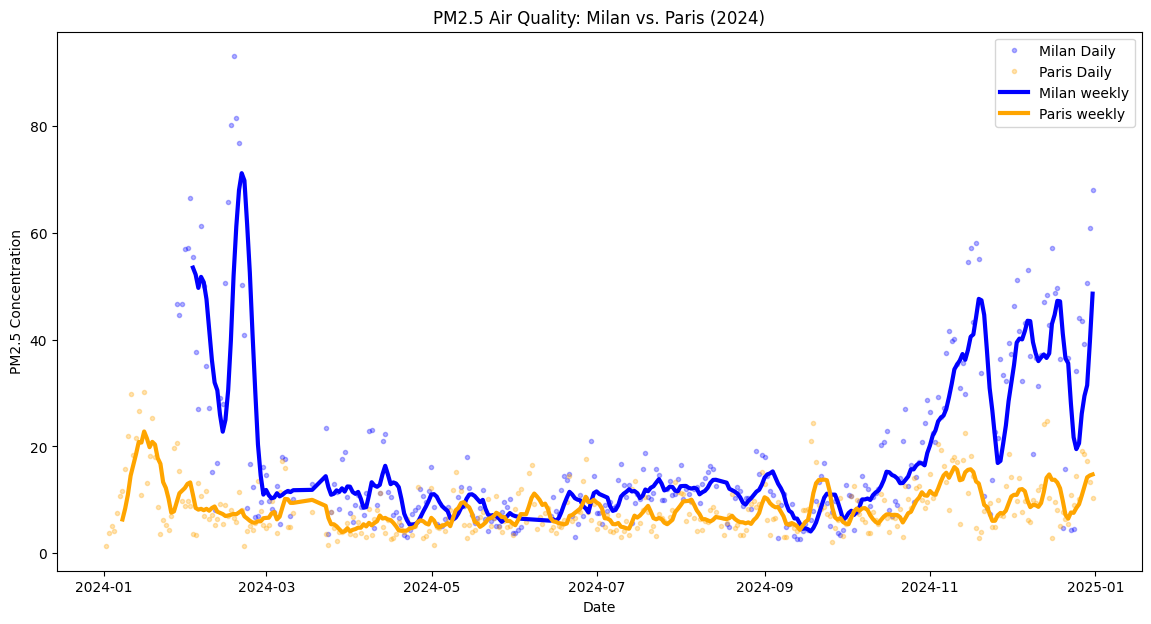

In [12]:
#PLOT 1: TIME SERIES TRENDS
df = pd.read_csv("clean all data 2024.csv")
df["Date"] = pd.to_datetime(df["Date"])

# double check we are strictly in 2024
df= df[(df["Date"]>= "2024-01-01") & (df["Date"]<= "2024-12-31")]

# calculate daily average per city
# this combines all sensors in the city into one number
daily_df= df.groupby(["City", "Date"])["pm25_value"].mean().reset_index()

# separate the cities for plotting
milan_df= daily_df[daily_df["City"]== "Milan"]
paris_df= daily_df[daily_df["City"]== "Paris"]

#plot raw daily dots
# alpha=0.3 makes them transparent so we can see where points overlap
plt.figure(figsize= (14,7))
plt.plot(milan_df["Date"], milan_df["pm25_value"], ".", color= "blue", alpha= 0.3, label= "Milan Daily")
plt.plot(paris_df["Date"], paris_df["pm25_value"], ".", color="orange", alpha= 0.3, label= "Paris Daily")

# calculate 7-day rolling average to smooth the lines
milan_weekly= milan_df.set_index("Date")["pm25_value"].rolling(window= 7).mean()
paris_weekly= paris_df.set_index("Date")["pm25_value"].rolling(window= 7).mean()

# plot the smoothed trend lines
plt.plot(milan_weekly.index, milan_weekly, color= "blue", linewidth= 3, label= "Milan weekly")
plt.plot(paris_weekly.index, paris_weekly, color= "orange", linewidth= 3, label= "Paris weekly")

# decoration
plt.title("PM2.5 Air Quality: Milan vs. Paris (2024)")
plt.ylabel("PM2.5 Concentration")
plt.xlabel("Date")
plt.legend()
plt.savefig('milan_paris_comparison.png', dpi=300, bbox_inches='tight')
print("Chart saved successfully!")
plt.show()

## 8. Visualization: Statistical Distribution (Box Plot)
Next, we use a Box Plot to compare the statistical spread of pollution levels in the two cities, ignoring the time component.

**Why Box Plots?**
* **The Box:** Shows the Interquartile Range (IQR), where the middle 50% of the data lies.
* **The Line:** The line inside the box represents the **Median** pollution level.
* **The Whiskers & Dots:** These show the range of "normal" data and the **Outliers** (extreme pollution days). This allows us to instantly see that Milan has a much higher variance and more extreme outlier events than Paris.

Chart saved successfully!


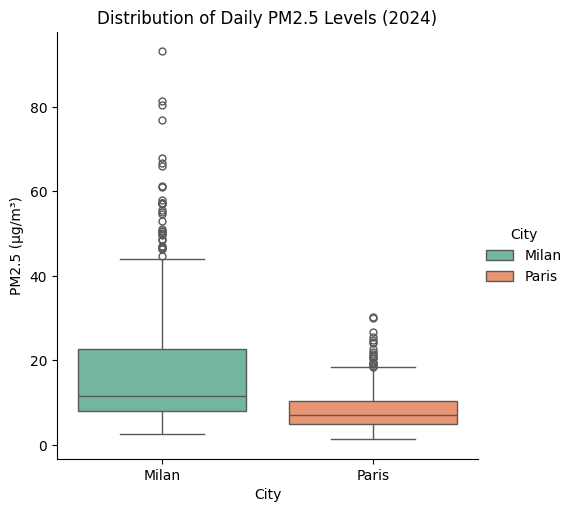

In [13]:
#PLOT 2: STATISTICAL DISTRIBUTION (BOX PLOT)

# kind="box" draws the box-and-whisker diagram
# hue="City" colors the boxes differently based on the city
sns.catplot(data= daily_df, x= "City", y= "pm25_value", kind= "box", hue="City", palette= "Set2", legend= True)
# decoration
plt.title("Distribution of Daily PM2.5 Levels (2024)")
plt.ylabel("PM2.5 (µg/m³)")
plt.savefig('milan_paris_comparison2.png', dpi=300, bbox_inches='tight')
print("Chart saved successfully!")
plt.show()

## 9. Visualization: Frequency Histogram
Finally, we generate a histogram to analyze the **probability distribution** of pollution levels.
* **Density Plot:** We set `density=True` to normalize the data. This allows us to compare the *shape* of the distribution (probability) rather than just the raw count of days.
* **The "Tail":** This visualization clearly highlights the "fat tail" in Milan's data—showing that while Paris is tightly clustered around low values, Milan frequently experiences high-pollution events.
* **WHO Benchmark:** We add a red dashed line at **15 µg/m³** (WHO annual target) to visually distinguish between "safe" and "unsafe" days.

Chart saved successfully!


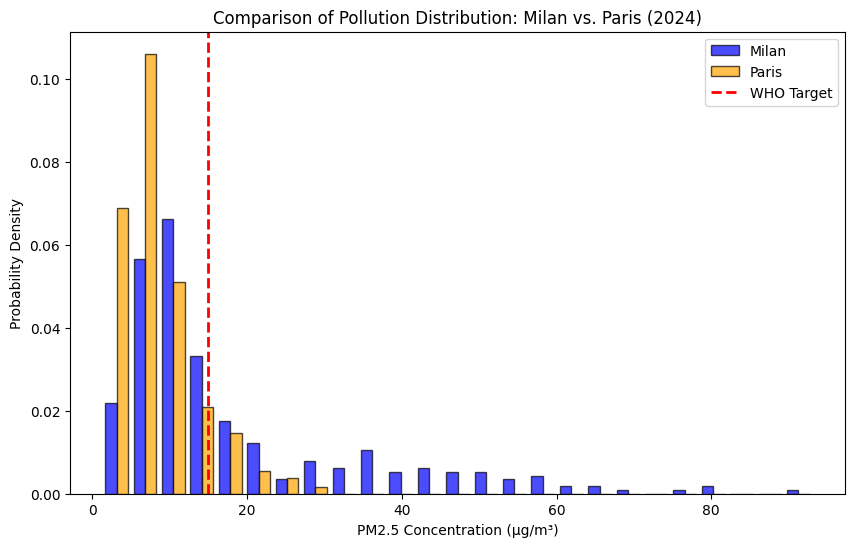

In [14]:
# PLOT 3: FREQUENCY HISTOGRAM

plt.figure(figsize=(10, 6))

# prepare data as a list for side-by-side plotting
milan_values = daily_df[daily_df["City"] == 'Milan']['pm25_value']
paris_values = daily_df[daily_df["City"] == 'Paris']['pm25_value']
data_to_plot = [milan_values, paris_values]

# plot histograms together
# density=True: it lets us compare probability instead of just counts
plt.hist(data_to_plot, bins=25, color=['blue', 'orange'], label=['Milan', 'Paris'], 
         alpha=0.7, edgecolor='black', density=True)

# add the WHO safety guideline as a benchmark
plt.axvline(x=15, color='red', linestyle='--', linewidth=2, label='WHO Target')

# Decoration
plt.title("Comparison of Pollution Distribution: Milan vs. Paris (2024)")
plt.xlabel("PM2.5 Concentration (µg/m³)")
plt.ylabel("Probability Density")
plt.legend()
plt.savefig('milan_paris_comparison3.png', dpi=300, bbox_inches='tight')
print("Chart saved successfully!")
plt.show()